**ТОВАРНЫЕ РЕКОМЕНДАЦИИ ДЛЯ E-COMM**

**Часть 1 - Препроцессинг**

**Датасет**:  Описывает лог покупок в интернет магазине за определенный период

**Цель**: На основании данных предоставить товарные рекомендации для последующей рассылки в рамках Email маркетинга для клиентов

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from datetime import date
from datetime import timedelta

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
# настройка размера графиков
plt.rcParams["figure.figsize"] = (12,6)

In [3]:
plt.style.use('ggplot') # выбор стиля графиков по умолчанию

In [4]:
# форматирование дробных чисел

pd.options.display.float_format = '{:.3f}'.format

# Загрузка

In [5]:
df = pd.read_csv('ecommerce_dataset.csv')
df.sample(3)

,date,customer_id,order_id,product,quantity,price
6546,2019100904,5a15bd5f-ecf4-496f-913c-23d6f76a2f8d,72901,Пуансеттия d-23 см красная,1,374.000
5285,2019061409,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Сосновский, кассета по 6шт",1,120.000
2311,2019031316,7d7f5e10-3025-4c74-879e-0b3b064475a8,70677,"Скалка силиконовая, Lekue, 0200800M02U050",1,1312.000


Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [7]:
for x in ['customer_id', 'order_id', 'product']:
    print(x,':', df[x].nunique())
    print('---')

customer_id : 2451
---
order_id : 2784
---
product : 2343
---


# Типы и пропуски

In [8]:
# форматируем время

df['timestamp'] = pd.to_datetime(df['date'], format='%Y%m%d%H')  
df['date'] = df['timestamp'].dt.normalize() # оставляем время, как отдельную колонку
df.sample()

,date,customer_id,order_id,product,quantity,price,timestamp
4368,2019-06-03,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Сосновский, кассета по 6шт",1,120.000,2019-06-03 08:00:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6737 non-null   datetime64[ns]
 1   customer_id  6737 non-null   object        
 2   order_id     6737 non-null   int64         
 3   product      6737 non-null   object        
 4   quantity     6737 non-null   int64         
 5   price        6737 non-null   float64       
 6   timestamp    6737 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 368.6+ KB


In [10]:
print('Период в датасете:', df['timestamp'].min(), '-',  df['timestamp'].max())

Период в датасете: 2018-10-01 00:00:00 - 2019-10-31 16:00:00


In [11]:
# проверка на пропуски

df.isnull().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
timestamp      0
dtype: int64

# Поиск дубликатов

In [12]:
df = df.sort_values(by='timestamp')

In [13]:
print('Количество полных дубликатов: {:.2%}'.format(len(df[df.duplicated()]) /len(df)))
print('Количество дубликатов по дате: {:.2%}'.format(len(df[df.duplicated(subset=df.columns[:-1])]) /len(df)))
print('Количество дубликатов по заказу и товару: {:.2%}'.format(len(df[df.duplicated(subset=df.columns[1:6])]) /len(df)))

Количество полных дубликатов: 0.00%
Количество дубликатов по дате: 14.34%
Количество дубликатов по заказу и товару: 27.67%


## Исследование дубликатов

In [14]:
# сколько процентов заказов, которые повторяются в другие дни?

df.groupby('order_id')['date'].nunique().value_counts(normalize=True).sort_index()

1    0.932
2    0.049
3    0.011
4    0.002
5    0.002
6    0.001
7    0.000
11   0.001
15   0.000
22   0.000
57   0.000
Name: date, dtype: float64

In [15]:
n_delta_orders = df[df.duplicated(subset=df.columns[:-1])].groupby('order_id').agg({'date':['min', 'max']}).reset_index()
n_delta_orders['delta'] = n_delta_orders['date', 'max'] - n_delta_orders['date', 'min']
n_delta_orders['delta'] = n_delta_orders['delta'].dt.days

In [16]:
n_delta_orders

order_id       date            delta
                    min        max      
0      14500 2018-10-28 2018-10-31     3
1      14521 2019-01-10 2019-01-10     0
2      14541 2019-02-17 2019-02-17     0
3      14566 2019-03-07 2019-03-07     0
4      14570 2019-03-12 2019-03-12     0
..       ...        ...        ...   ...
141    73095 2019-10-26 2019-10-26     0
142    73101 2019-10-27 2019-10-27     0
143    73104 2019-10-27 2019-10-27     0
144    73108 2019-10-28 2019-10-28     0
145    73136 2019-10-31 2019-10-31     0

[146 rows x 4 columns]

In [17]:
# сколько дубликатов

n_delta_orders['delta'].value_counts(normalize=True).sort_index()

0     0.911
1     0.021
2     0.014
3     0.014
4     0.014
6     0.007
22    0.014
122   0.007
Name: delta, dtype: float64

## Удаление дубликатов

In [18]:
# быстрое удаление дубликатов

df = df.drop_duplicates(subset=df.columns[1:6])

In [19]:
print('Количество полных дубликатов: {:.2%}'.format(len(df[df.duplicated()]) /len(df)))
print('Количество дубликатов по дате: {:.2%}'.format(len(df[df.duplicated(subset=df.columns[:-1])]) /len(df)))
print('Количество дубликатов по заказу и товару: {:.2%}'.format(len(df[df.duplicated(subset=df.columns[1:6])]) /len(df)))

Количество полных дубликатов: 0.00%
Количество дубликатов по дате: 0.00%
Количество дубликатов по заказу и товару: 0.00%


# Добавление вычисляемых метрик

## Стоимость

In [20]:
df['cost'] = df['quantity'] * df['price']

In [21]:
df['cost'].describe()

count     4873.000
mean       850.021
std       9807.308
min          9.000
25%        120.000
50%        194.000
75%        734.000
max     675000.000
Name: cost, dtype: float64

## Порядковый номер заказа

In [22]:
df.sort_values('timestamp', inplace = True) # сортируем датасет

# формируем таблицу для расчета порядкового номера заказа
temp = df[['order_id', 'customer_id']].drop_duplicates()

# высчитывываем количество уникальных номеров заказа на одного юзера

temp['index_by_user'] = 1
temp['index_by_user'] = temp.groupby('customer_id')['index_by_user'].cumcount()

temp.index_by_user = temp.index_by_user + 1

In [23]:
df = df.merge(temp[['order_id', 'index_by_user']], on='order_id')
df.rename(columns = {'index_by_user':'serial_number_order'}, inplace = True)

In [24]:
# проверяем распределение по количеству заказов

df.serial_number_order.value_counts().sort_index()

1      4381
2       294
3        60
4        19
5         9
       ... 
122       1
123       1
124       1
125       1
126       1
Name: serial_number_order, Length: 126, dtype: int64

## Постоянные клиента

In [25]:
# является ли клиент постоянным

df['is_regular_customer'] = df['order_id'].apply(lambda x: 1 if x in 
                                  (df[df['customer_id'].isin(
                                      df[df['serial_number_order']==2]['customer_id'].unique())]
                                   ['order_id'].unique()) else 0)

In [26]:
df['is_regular_customer'].value_counts()

0    4024
1     929
Name: is_regular_customer, dtype: int64

## Категории

In [27]:
# hotfix

df['product'] = df['product'].str.lower().str.replace(r'ё', 'е')
df['product'] = df['product'].str.lower().str.replace(r'tepмокружка', 'термокружка')
df['product'] = df['product'].str.lower().str.replace(r'наматрицник', 'наматрацник')

### Простой способ
На основе первого слова в названии товара

In [28]:
# поиск первого слова

df['first_word'] = df['product'].str.lower().str.split(r'( )', expand=True)[0]

In [29]:
# количество уникальных первых слов

n_first_word = df['first_word'].nunique()
n_first_word

457

In [30]:
print('Среднее количество товаров в одном уникальном первом слове: {:.2f}'.format(1 / (n_first_word / df['product'].nunique())))

Среднее количество товаров в одном уникальном первом слове: 5.12


### Продвинутый способ 
На основе первого существительного в названии товара

In [31]:
# регулярное выражение для поиска прилагательных слов

is_adjective = re.compile('[а-я]{3,}[кншлжшчвдщц](?!ия|ие|ея|ей)[ауеыиоюя][йяе]$')

# любые 3 и более кирилических символа
# согласные из набора [кншлжшчвдщц]
# с учетом отсутствия любого из следующих символов ия|ие|ея|ей после согласных
# гласные из набор [ауеыиоюя]
# гласные из набора [йяе]
# конец строки

In [32]:
# проверка работы регулярки
count = 0
for x in df['product'].str.lower().str.split(r'( |-|,)', expand=True)[0].unique():
    if count > 5:
        break
    if re.findall(is_adjective, x) != []:
        print(x)
        count = count +1

комнатное
настенная
стеклянная
многолетнее
мусорный
гладильная


In [33]:
# найдем все прилагательные в первых и вторых словах названий товаров

not_nouns = []
for product in df['product'].drop_duplicates().str.lower().str.split(r'( |-|,)', expand=True)[0].unique():
    if re.findall(is_adjective, product) != []:
        not_nouns.append(product)
        
for product in df['product'].drop_duplicates().str.lower().str.split(r'( |-|,)', expand=True)[2].unique():
    if re.findall(is_adjective, product) != []:
        not_nouns.append(product)
        
not_nouns = set(not_nouns)

In [34]:
# найдено уникальных прилагательных
len(not_nouns)

255

In [35]:
def get_name(value):
    # сохраняем полученное значение в список
    temp_list = re.split(r'( |-|,)', str(value.lower()))

    # проверяем, что каждое из двух первых слов не входит в список
    
    if temp_list[0] not in not_nouns:
        return(temp_list[0]) # возвращает первое слово
    elif temp_list[2] not in not_nouns:
        return(temp_list[2]) # возвращает второе слово
    else:
        return(temp_list[4]) # возвращает третье слово

In [36]:
# применяем функцию 

df['category'] = df['product'].apply(lambda x: get_name(x))

In [37]:
df['category'].value_counts()

пеларгония     714
рассада        479
сушилка        292
сумка          250
муляж          195
              ... 
гель             1
кипятильник      1
горох            1
иссоп            1
циния            1
Name: category, Length: 404, dtype: int64

In [38]:
# количество уникальных категорий

n_category = df['category'].nunique()
n_category

404

In [39]:
# есть ли короткие названия категорий (например, предлоги)
df[df['category'].str.len() < 3]

,date,customer_id,order_id,product,quantity,price,timestamp,cost,serial_number_order,is_regular_customer,first_word,category


In [40]:
# есть ли в названии цифры
df[df['category'].str.contains(r'\d+')]

,date,customer_id,order_id,product,quantity,price,timestamp,cost,serial_number_order,is_regular_customer,first_word,category


In [41]:
# есть ли в названии английские символы
df[df['category'].str.contains(r'[a-z]+')]

,date,customer_id,order_id,product,quantity,price,timestamp,cost,serial_number_order,is_regular_customer,first_word,category


In [42]:
print('Среднее количество товаров в одной уникальной категории: {:.2f}'.format(1 / (n_category / df['product'].nunique())))

Среднее количество товаров в одной уникальной категории: 5.79


### Дополнительные вычисления

In [43]:
# сверяем расхождения у первого слова и первого существительного

(df[df['first_word']!=df['category']]
 [['first_word','category', 'product']]
 .drop_duplicates(subset=['first_word', 'category'])
 .sort_values('first_word'))

,first_word,category,product
2586,автоматическая,щетка,автоматическая щетка leifheit для мытья окон с...
930,ароматизированное,средство,ароматизированное средство дудаления известков...
2628,бельевые,прищепки,бельевые прищепки york классик 20 шт g96010
4644,вакуумный,пакет,вакуумный пакет eva для хранения вещей 50х85 с...
1402,вешалка-перекладина,вешалка,вешалка-перекладина valiant металлическая двой...
...,...,...,...
648,чайная,ложка,чайная ложка better цветной горох bt-c2003e-td...
576,чайный,набор,чайный набор luminarc рейнбоу 220 мл j5978
231,чистящий,крем,чистящий крем для трудновыводимых пятен mama l...
42,щетка-сметка,щетка,щетка-сметка 3-х рядная деревянная 450 мм (пло...


In [44]:
# ищем одинаковые слова, но с разными окончаниями

list = df['category'].sort_values().unique()
n = len(list)

for i in range(n-1) :
    for j in range(i+1,n) :
        res = len(set(list[i]) ^ set(list[j]))
        if list[i][0:3] == list[j][0:3]:
            if res < 3 and res < len(list[j]) / 3:
                word1 = list[i]
                word2 = list[j]
                print(word1,word2, res)

бальзам бальзамин 2
веник венчик 1
вешалка вешалки 1
календула каллуна 2
калла каллуна 2
корзина корзинка 0
корзина кориандр 2
корзинка кориандр 2
короб коробка 1
наматрасник наматрацник 2
полки половник 2
простынь простыня 2
пуансетия пуансеттия 0
салфетка салфетки 1
стремянка стремянки 2
термометр термос 1
томат томата 0
цинерания цинерария 0
циния цинния 0


In [45]:
# список однокоренных слов, но с разными окончаниями (лемматизация на коленке)

check = [
    'вешалка', 'вешалки',
    'корзина', 'корзинка',
    'короб', 'коробка',
    'наматрасник', 'наматрацник',
    'простынь', 'простыня',
    'пуансетия', 'пуансеттия',
    'салфетка', 'салфетки',
    'стремянка', 'стремянки',
    'томат', 'томата',
    'цинерания', 'цинерария',
    'циния', 'цинния',
]

In [46]:
check_data = df[df['category'].isin(check)]['category']
check_data = check_data.value_counts(normalize=True).sort_values().reset_index()

In [47]:
# создаем рейтинг того, как часто встречается то или иное описание

check_data = check_data.sort_values('index')
check_data.head(6)

,index,category
20,вешалка,0.165
11,вешалки,0.012
19,корзина,0.101
3,корзинка,0.003
7,короб,0.006
15,коробка,0.021


In [48]:
# заменяем слово из пары на то, которое более чаще встречается в датасете

for x in range(0,check_data['index'].nunique(),2):
    if check_data['category'].iloc[x] > check_data['category'].iloc[x+1]:
        df['category'].replace(check_data['index'].iloc[x+1], check_data['index'].iloc[x], inplace=True)
    else:
        df['category'].replace(check_data['index'].iloc[x], check_data['index'].iloc[x+1], inplace=True)
    

In [49]:
# проверяем результат

df[df['category'].str.contains('вешалк')]['category'].unique()

array(['вешалка'], dtype=object)

In [50]:
n_category = df['category'].nunique()
n_category

393

In [51]:
print('Среднее количество товаров в одной уникальной категории: {:.2f}'.format(1 / (393 / df['product'].nunique())))

Среднее количество товаров в одной уникальной категории: 5.96


In [52]:
# назначим категорию "другое" для всех товарных категорий, которые встречаются всего лишь 1 раз в датасете

temp = df['category'].value_counts().reset_index()
temp = temp[temp['category'] == 1]

# df['category_upd'] = df['category']
df['category'] = df['category'].apply(lambda x: 'другое' if x in temp['index'].unique() else x)

In [53]:
n_category = df['category'].nunique()
n_category

235

In [54]:
print('Среднее количество товаров в одной уникальной категории: {:.2f}'.format(1 / (n_category / df['product'].nunique())))

Среднее количество товаров в одной уникальной категории: 9.96


# Поиск аномалий

## Изучаем метрику цены товаров

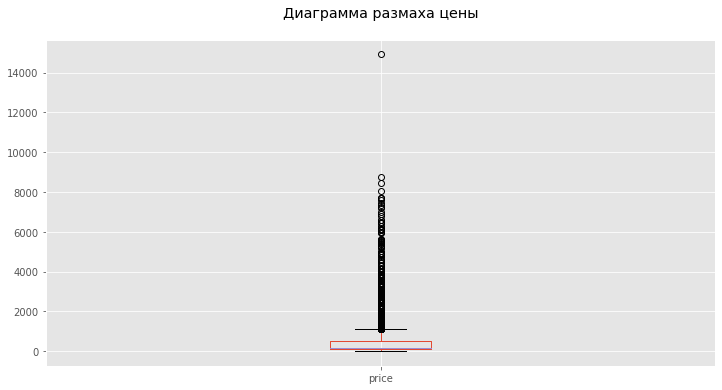

In [55]:
df['price'].plot(kind='box')

plt.title('Диаграмма размаха цены'+'\n');

In [56]:
# посмотрим на крайник квантили
df['price'].quantile([.9, 0.95, 0.99, 0.995])

0.900   1424.000
0.950   2174.000
0.990   4949.000
0.995   6105.880
Name: price, dtype: float64

In [57]:
df['price'].value_counts(bins=10, normalize=True)

(-5.909000000000001, 1499.8]   0.906
(1499.8, 2990.6]               0.063
(2990.6, 4481.4]               0.018
(4481.4, 5972.2]               0.006
(5972.2, 7463.0]               0.004
(7463.0, 8953.8]               0.001
(13426.2, 14917.0]             0.000
(11935.4, 13426.2]             0.000
(10444.6, 11935.4]             0.000
(8953.8, 10444.6]              0.000
Name: price, dtype: float64

In [58]:
df.groupby('product')['price'].max().sort_values(ascending=False).head(10)

product
сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая               14917.000
сумка-тележка хозяйственная andersen royal shopper, hera, синяя 166-004-90                8737.000
сумка-тележка хозяйственная andersen alu star shopper, hava, синяя 115-103-90             8437.000
сумка-тележка хозяйственная rolser mnb019 rojo logic dos+2 красная                        8077.000
стремянка 7 ступенчатая hailo 8040-707 xxl 13 см алюминиевая с лотком для инструментов    7724.000
сумка-тележка хозяйственная rolser mnb017 fucsia logic dos+2 фуксия                       7679.000
сумка-тележка хозяйственная rolser imx006 bassi logic tour бордовая                       7679.000
сумка-тележка хозяйственная rolser mou041 malva rd6 сиреневая                             7597.000
гладильная доска leifheit airboard compact m plus 120х38 см малиновый 71630               7424.000
урна уличная стальная сальвадор 02.021.0 46х110 см                                        7349.000
Na

In [59]:
# найдем товары, которые имеют и вылеты и нормальную цену

df[df['product'].isin(df[(df['price'] < 2990)&(df['product']
    .isin(df[df['price'] > 2990]['product'].unique()))]['product'])]

,date,customer_id,order_id,product,quantity,price,timestamp,cost,serial_number_order,is_regular_customer,first_word,category
1276,2019-01-09,d247211c-d16b-43ba-812d-6a27aff31871,69750,сумка-тележка хозяйственная gimi rolling therm...,1,2999.000,2019-01-09 14:00:00,2999.000,1,0,сумка-тележка,сумка
4319,2019-08-03,71b64fbc-4b00-4f9a-8cdc-8632d6aff974,72198,сумка-тележка хозяйственная gimi rolling therm...,1,2025.000,2019-08-03 22:00:00,2025.000,1,0,сумка-тележка,сумка


Видно, что кроме сумки-тележки другие товары отсутстуют

In [60]:
df[df['price'] > 2990].groupby('category')['price'].mean()

category
афеляндра     3524.000
ведро         3749.000
гортензия     3599.000
дерево        3524.000
доска         3963.250
другое        3411.500
ерш           3524.000
коврик        3917.750
комплект      5399.000
контейнер     5512.000
набор         5399.000
наматрацник   3074.000
одеяло        4724.000
покрывало     5496.500
полки         3780.333
сиденье       6149.000
стремянка     4270.917
сумка         4859.141
сушилка       4726.111
урна          6102.250
швабра        3224.000
штора         3899.500
щетка         7229.000
Name: price, dtype: float64

**Вывод**

Критических аномалий не найдено. Было принято решение оставить датасет в данной части без изменений.

## Изучаем метрику количества товаров

<AxesSubplot:>

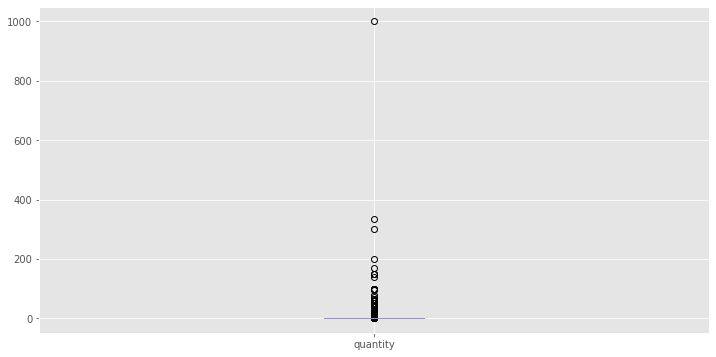

In [61]:
df['quantity'].plot(kind='box')

In [62]:
df['quantity'].value_counts(bins=10, normalize=True)

(0.0, 100.9]      0.998
(100.9, 200.8]    0.001
(900.1, 1000.0]   0.000
(300.7, 400.6]    0.000
(200.8, 300.7]    0.000
(800.2, 900.1]    0.000
(700.3, 800.2]    0.000
(600.4, 700.3]    0.000
(500.5, 600.4]    0.000
(400.6, 500.5]    0.000
Name: quantity, dtype: float64

In [63]:
(df[df['product']
    .isin(df.groupby('product')['quantity']
          .max().sort_values(ascending=False)
          .head().index)]
 .sort_values('product'))

,date,customer_id,order_id,product,quantity,price,timestamp,cost,serial_number_order,is_regular_customer,first_word,category
3896,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.000,2019-06-18 15:00:00,675000.000,1,0,вантуз,вантуз
3830,2019-06-11,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.000,2019-06-11 07:00:00,49432.000,1,0,вешалки,вешалка
3859,2019-06-13,bc507650-4585-400d-874e-078d5bf3b36e,71694,вешалки мягкие для деликатных вещей 3 шт шоколад,1,164.000,2019-06-13 11:00:00,164.000,1,0,вешалки,вешалка
476,2018-10-30,9804e44f-bf1d-4b3a-992f-e2a575b43b7d,68806,муляж яблоко 9 см красное,4,59.000,2018-10-30 23:00:00,236.000,1,0,муляж,муляж
487,2018-11-01,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.000,2018-11-01 08:00:00,8670.000,1,0,муляж,муляж
505,2018-11-02,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59.000,2018-11-02 11:00:00,8260.000,1,0,муляж,муляж
719,2018-11-17,2c2b3410-8218-4671-a208-4d20ed55056a,69028,муляж яблоко 9 см красное,1,59.000,2018-11-17 01:00:00,59.000,1,0,муляж,муляж
3432,2019-05-20,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.000,2019-05-20 21:00:00,15300.000,1,0,муляж,муляж
4902,2019-10-22,a0364684-750b-4162-9d19-9ad371a240df,73057,муляж яблоко 9 см красное,3,59.000,2019-10-22 12:00:00,177.000,1,0,муляж,муляж
198,2018-10-11,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.000,2018-10-11 14:00:00,5700.000,1,0,пружина,другое


In [64]:
df = df[df['quantity']<333]

**Вывод**

Найдены критические аномалии для двух товаров:
1. вантуз с деревянной ручкой в количестве 1000 шт.
2. вешалки мягкие для деликатных вещей 3 шт шоколад в количестве 334 шт.

Данные аномалии были удалены из датасета

## Изучаем метрику стоимости

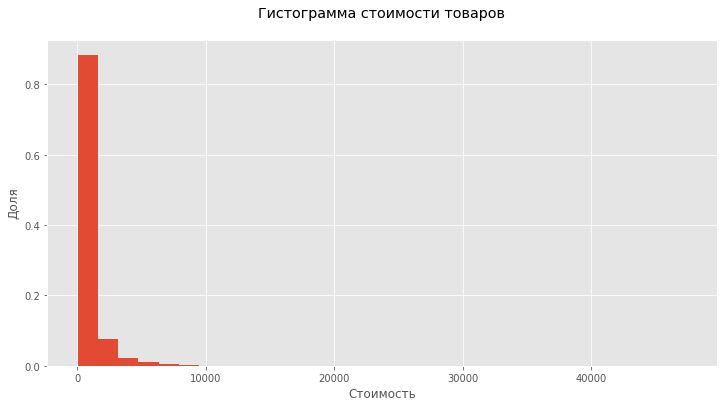

In [65]:
df['cost'].plot.hist(weights = np.ones_like(df.index) / len(df.index), bins=30)

plt.title('Гистограмма стоимости товаров'+ '\n')
plt.xlabel('Стоимость')
plt.ylabel('Доля')

plt.show()

**Комментарий**

Судя по гистограмме выше наблюдается небольшое количество товаров со стоимостью более 3000 рублей. Изучим гистограмму количества товаров для такой стоимости.

In [66]:
df['cost'].quantile(.95)

2849.0

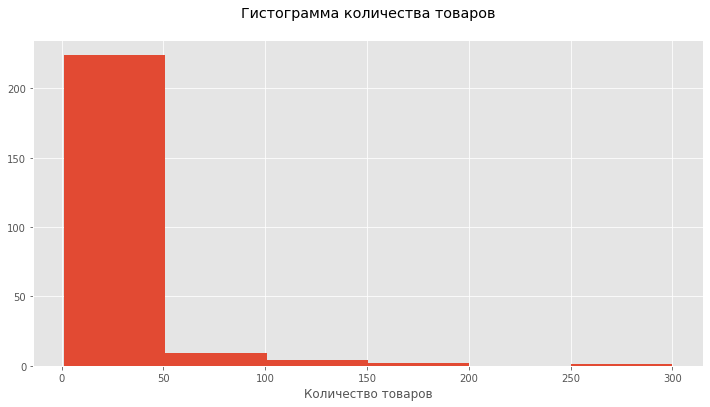

In [67]:
df[df['cost'] > df['cost'].quantile(.95)].sort_values('product')['quantity'].hist(bins=6)

plt.title('Гистограмма количества товаров'+ '\n')
plt.xlabel('Количество товаров')

plt.show()

**Комментарий**

Судя по гистограмме выше значимая часть товаров с высокой стоимостью обслуловлена количеством товаров до 20

In [68]:
# сформируем таблицу с характеристиками по общему количеству товаров и количеству уникальных SKU

temp = df.groupby('order_id').agg({'quantity':'sum','product':'nunique'}).reset_index().sort_values('quantity', ascending=False)

# Рассчитаем дельту, как отношение количества товаров к количеству уникальных SKU
temp['delta'] = temp['quantity'] / temp['product']
temp

,order_id,quantity,product,delta
2608,72845,640,1,640.000
1912,71478,300,1,300.000
405,68611,300,2,150.000
800,69289,200,1,200.000
534,68815,170,1,170.000
...,...,...,...,...
1300,70301,1,1,1.000
1299,70300,1,1,1.000
1298,70294,1,1,1.000
1297,70293,1,1,1.000


<AxesSubplot:>

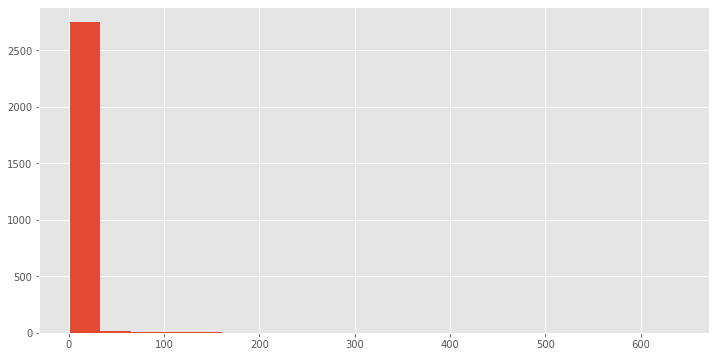

In [69]:
temp['delta'].hist(bins=20)

In [70]:
x = 10

temp = df.groupby('order_id').agg({'quantity':'sum','product':'nunique'}).reset_index().sort_values('quantity', ascending=False)
temp['delta'] = temp['quantity'] / temp['product']


df.loc[df['order_id'].isin(temp[temp['delta']>x-1]['order_id']), 'is_opt_order'] = 1
df['is_opt_order'] = df['is_opt_order'].fillna(0)

In [71]:
df.is_opt_order.value_counts()

0.000    4708
1.000     243
Name: is_opt_order, dtype: int64

In [72]:
# оставим только данные о не оптовых заказах в датасете

df_opt = df[df['is_opt_order'] == 1]
df = df[df['is_opt_order'] == 0]

# Описание

## Изменения в периоде

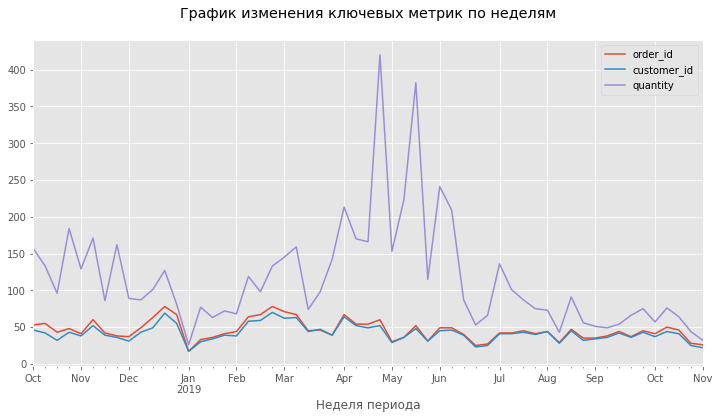

In [73]:
df.groupby(pd.Grouper(key='timestamp', freq='W'))['order_id'].nunique().plot(legend=True)
df.groupby(pd.Grouper(key='timestamp', freq='W'))['customer_id'].nunique().plot(legend=True)
df.groupby(pd.Grouper(key='timestamp', freq='W'))['quantity'].sum().plot(legend=True)

plt.xlabel('Неделя периода')
plt.title('График изменения ключевых метрик по неделям'+'\n');

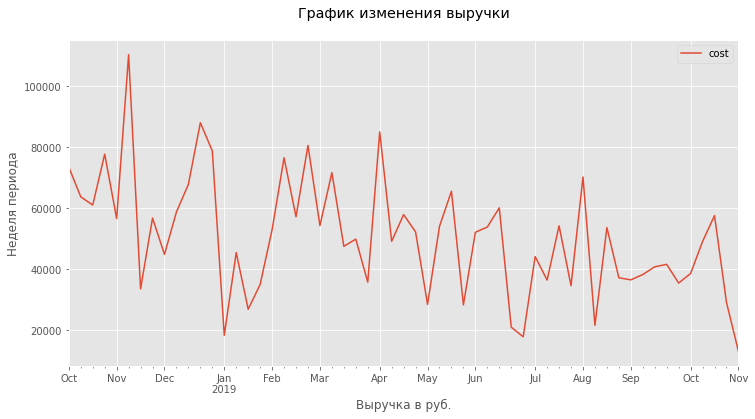

In [74]:
df.groupby(pd.Grouper(key='timestamp', freq='W'))['cost'].sum().plot(legend=True)

plt.xlabel('Выручка в руб.')
plt.ylabel('Неделя периода')
plt.title('График изменения выручки'+'\n');

# Заключение

In [75]:
for x in ['customer_id', 'order_id', 'product']:
    print(x,':', df[x].nunique())
    print('---')

customer_id : 2284
---
order_id : 2586
---
product : 2231
---


**Итог**

Был произведен препроцессинг полученных данных:

Обработка датасета
- Исправление типов
- Удаление дубликатов

Добавление новых метрик
- Стоимость
- Порядковый номер заказа
- Флаг постоянного клиента
- Категория

Осуществлена работа с аномалиями
- Добавлен флаг оптового заказа

In [76]:
stop

NameError: name 'stop' is not defined

In [77]:
df.to_csv('ecommerce_dataset_preprocessed.csv', index=False)